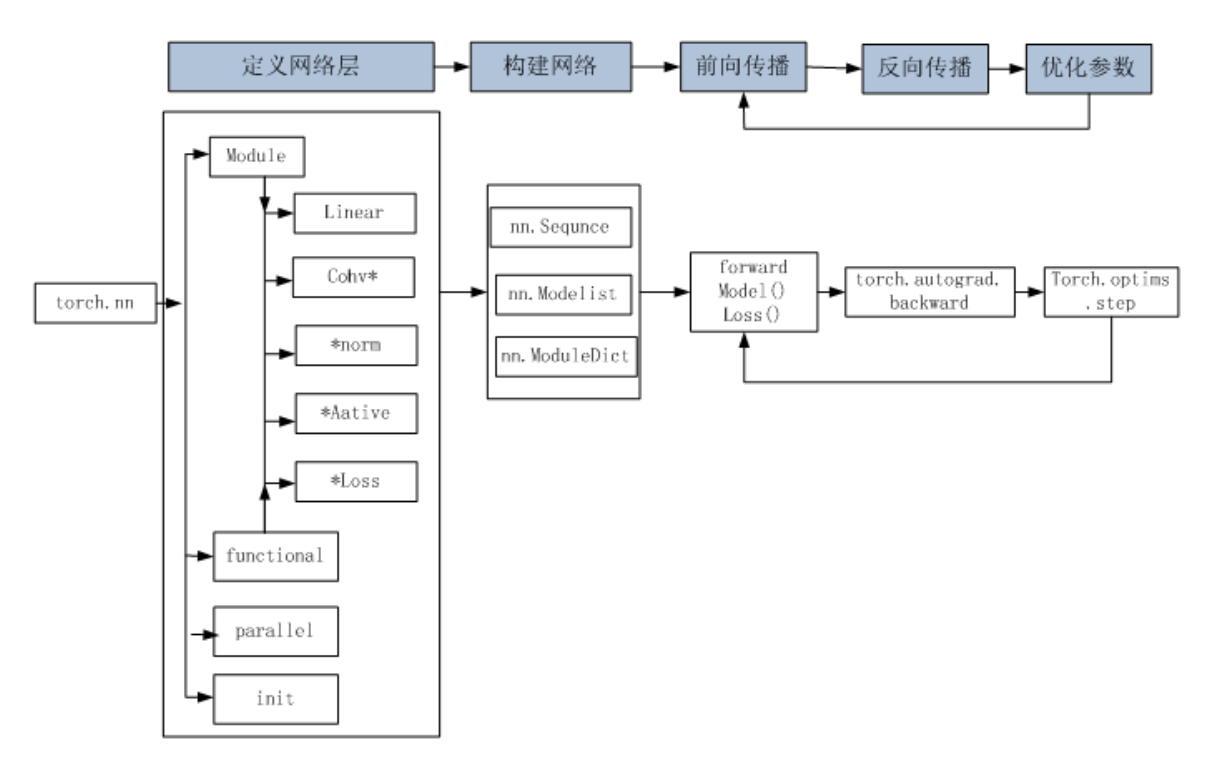

## 神经网络核心组件

（1）层：神经网络的基本结构，将输入张量转换为输出张量。  (torch.nn.Module)

（2）模型：层构成的网络。     ( torch.nn ) 

（3）损失函数：参数学习的目标函数，通过最小化损失函数来学习各种参数。  ( torch.nn )

（4）优化器：如何是损失函数最小，这就涉及到优化器。 torch.optim (SGD, ADAM)

* nn.functional中函数与nn.Module中的layer的主要区别是后者继承Module类，会自动提取可学习的参数。而nn.functional更像是纯函数。


* 卷积层、全连接层、dropout层等因含有可学习参数，一般使用nn.Module, 而激活函数、池化层不含可学习参数，可以使用nn.functional中对应的函数。


具体地说：（a）nn.Xxx继承于nn.Module，nn.Xxx 需要先实例化并传入参数，然后以函数调用的方式调用实例化的对象并传入输入数据。它能够很好的与nn.Sequential结合使用，而nn.functional.xxx无法与nn.Sequential结合使用。（b）nn.Xxx不需要自己定义和管理weight、bias参数；而nn.functional.xxx需要你自己定义weight、bias，每次调用的时候都需要手动传入weight、bias等参数, 不利于代码复用。（c）dropout操作在训练和测试阶段是有区别的，使用nn.Xxx方式定义dropout，在调用model.eval()之后，自动实现状态的转换，而使用nn.functional.xxx却无此功能。

总的来说，两种功能都是相同的，但PyTorch官方推荐：具有学习参数的（例如，conv2d, linear, batch_norm)采用nn.Xxx方式。没有学习参数的（例如，maxpool, loss func, activation func）等根据个人选择使用nn.functional.xxx或者nn.Xxx方式。

### 1. 基于MLP的多分类问题的例子

主要步骤：

（1）利用Pytorch内置函数mnist下载数据

（2）利用torchvision对数据进行预处理，调用torch.utils建立一个数据迭代器

（3）可视化源数据

（4）利用nn工具箱构建神经网络模型

（5）实例化模型，并定义损失函数及优化器

（6）训练模型

（7）可视化结果

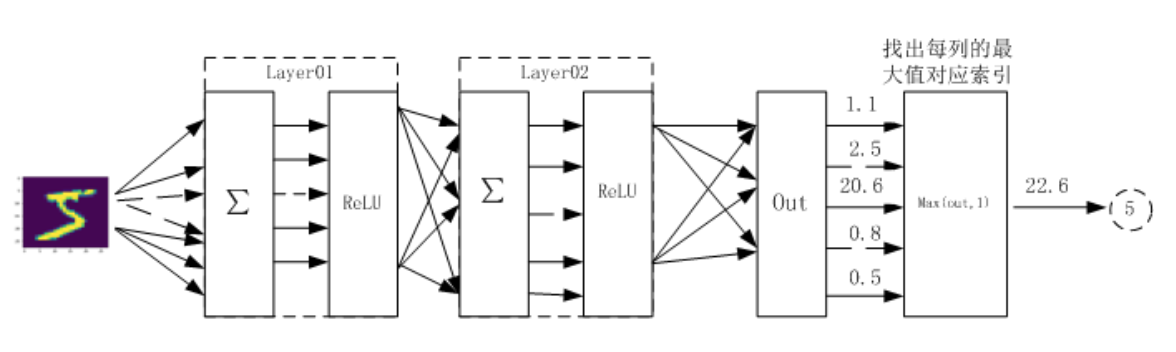

In [267]:
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist 
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn

In [268]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20
lr = 0.01
momentum = 0.5

In [269]:
#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

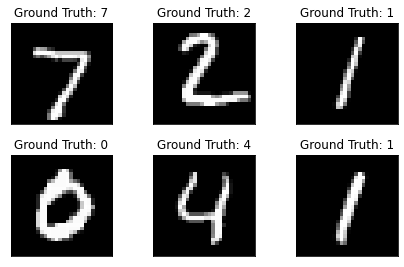

In [270]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

In [271]:
example_data.shape

torch.Size([128, 1, 28, 28])

In [272]:
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
        
 
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [273]:
#检测是否有可用的GPU，有则使用，否则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#实例化网络
model = Net(28 * 28, 300, 100, 10)
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [274]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
 
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
    for img, label in train_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img=img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader), 
                     eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 0, Train Loss: 1.0240, Train Acc: 0.7769, Test Loss: 0.5535, Test Acc: 0.8951
epoch: 1, Train Loss: 0.4825, Train Acc: 0.8996, Test Loss: 0.3573, Test Acc: 0.9221
epoch: 2, Train Loss: 0.3486, Train Acc: 0.9207, Test Loss: 0.2746, Test Acc: 0.9355
epoch: 3, Train Loss: 0.2829, Train Acc: 0.9327, Test Loss: 0.2312, Test Acc: 0.9465
epoch: 4, Train Loss: 0.2402, Train Acc: 0.9410, Test Loss: 0.2007, Test Acc: 0.9509
epoch: 5, Train Loss: 0.2233, Train Acc: 0.9453, Test Loss: 0.1954, Test Acc: 0.9521
epoch: 6, Train Loss: 0.2183, Train Acc: 0.9464, Test Loss: 0.1949, Test Acc: 0.9518
epoch: 7, Train Loss: 0.2173, Train Acc: 0.9465, Test Loss: 0.1908, Test Acc: 0.9525
epoch: 8, Train Loss: 0.2122, Train Acc: 0.9479, Test Loss: 0.1906, Test Acc: 0.9529
epoch: 9, Train Loss: 0.2102, Train Acc: 0.9489, Test Loss: 0.1882, Test Acc: 0.9528
epoch: 10, Train Loss: 0.2092, Train Acc: 0.9488, Test Loss: 0.1893, Test Acc: 0.9529
epoch: 11, Train Loss: 0.2089, Train Acc: 0.9487, Test Loss: 0.1

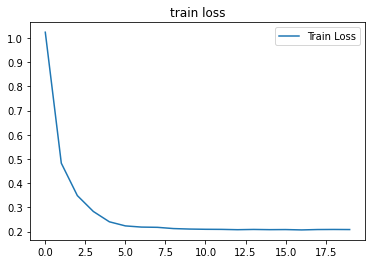

In [275]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')

### what can be customized？


In [ ]:
for epoch in range(num_epoches):
    #动态修改参数学习率
    if epoch%5==0:
        optimizer.param_groups[0]['lr']*=0.1
        print(optimizer.param_groups[0]['lr'])
    for img, label in train_loader:
       ######
    
    
# net_SGD = Net()
# net_Momentum = Net()
# net_RMSProp = Net()
# net_Adam = Net()
 
# nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
 
# opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
# opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
# opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
# opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
# optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]

### 2. Pytorch 训练模型及data工具箱

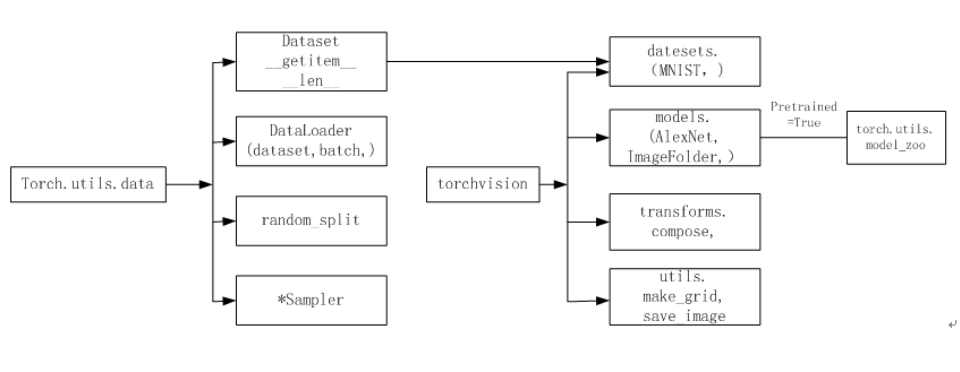

## 3.  tensorboardX简介

步骤：

（1）导入tensorboardX，实例化SummaryWriter类，指明记录日志路径等信息。 默认 `log_dir` is "runs"。


（2）调用相应的API接口

（3）启动tensorboard服务
cd到logs目录所在的同级目录，在命令行输入如下命令，logdir等式右边可以是相对路径或绝对路径。


### (1) scalar 

In [276]:
import sys, os
import numpy as np
os.getcwd()

'/Users/tinggao/Downloads'

In [277]:
from tensorboardX import SummaryWriter
#实例化SummaryWriter，并指明日志存放路径。在当前目录没有logs目录将自动创建。
writer = SummaryWriter(log_dir = 'scalar/test' , comment = 'test')


for epoch in range(100):
    #调用实例
    writer.add_scalar('scalar-logs', np.random.rand(), epoch)
    writer.add_scalars('scalars-logs', {'xsinx': epoch*np.sin(epoch), 'scosx': epoch * np.cos(epoch)}, epoch)

#关闭writer
writer.close()

In [278]:
#SummaryWriter. + Tab
?SummaryWriter

In [192]:
!tensorboard --logdir=/Users/tinggao/Downloads/scalar/test

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


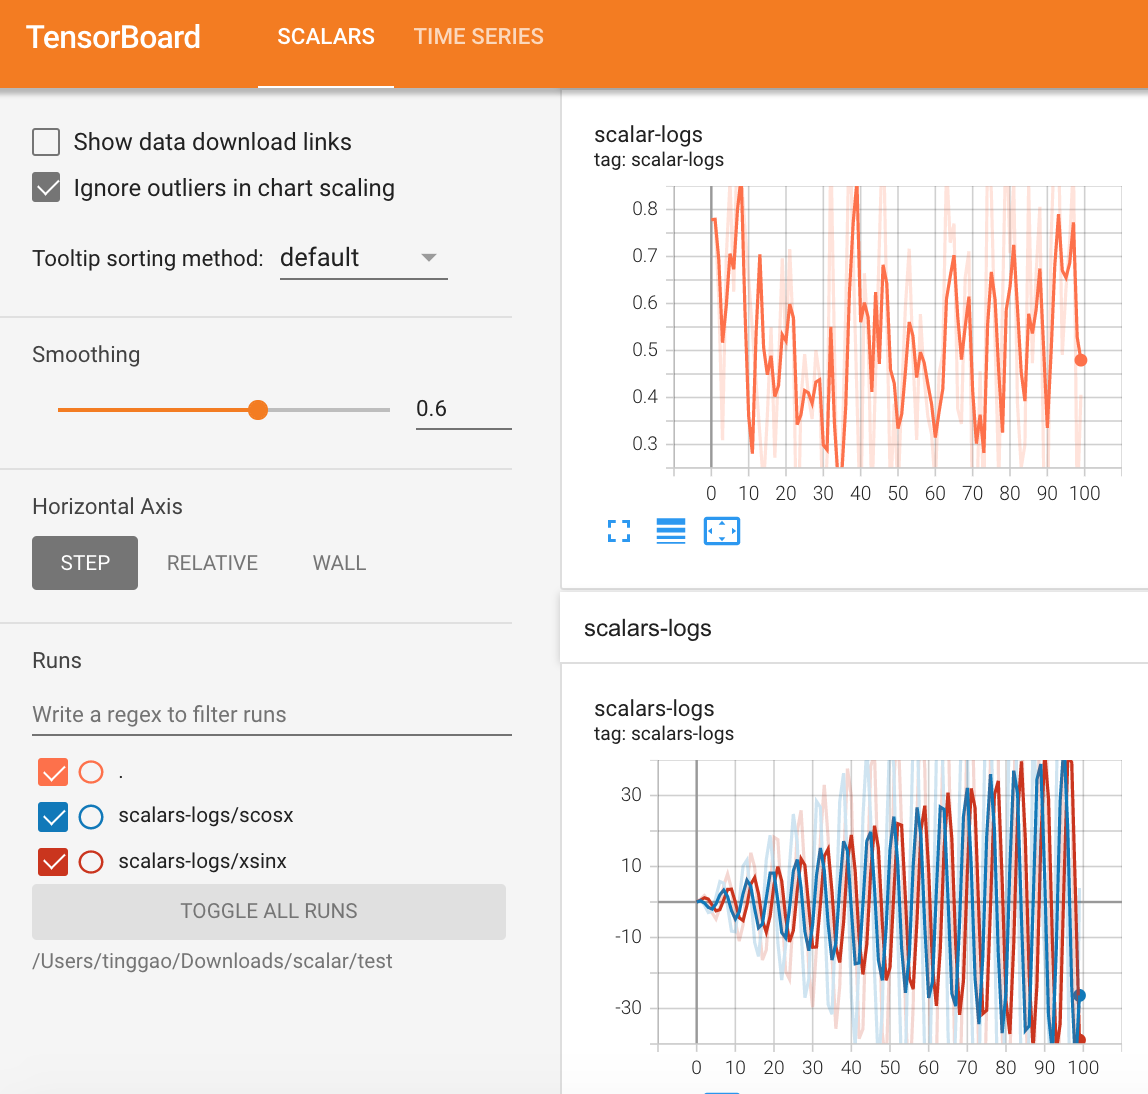


In [193]:
writer.close()

### (2) Graph

In [97]:
#!pip install --upgrade torch

In [99]:
#!pip install --upgrade tensorboard

In [101]:
#!pip install --upgrade torchvision

In [279]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tensorboard
from tensorboardX import SummaryWriter

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        self.bn = nn.BatchNorm2d(20)
 
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), 2)
        x = F.relu(x) + F.relu(-x)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.bn(x)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x


In [164]:
#?F.max_pool2d

In [280]:
#定义输入
input = torch.rand(32, 1, 28, 28)
#实例化神经网络
model = Net()
#将model保存为graph
writer = SummaryWriter(log_dir = 'logs' , comment = 'test')

In [281]:
writer.add_graph(model, (input, ))

In [186]:
!tensorboard --logdir=/Users/tinggao/Downloads/logs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


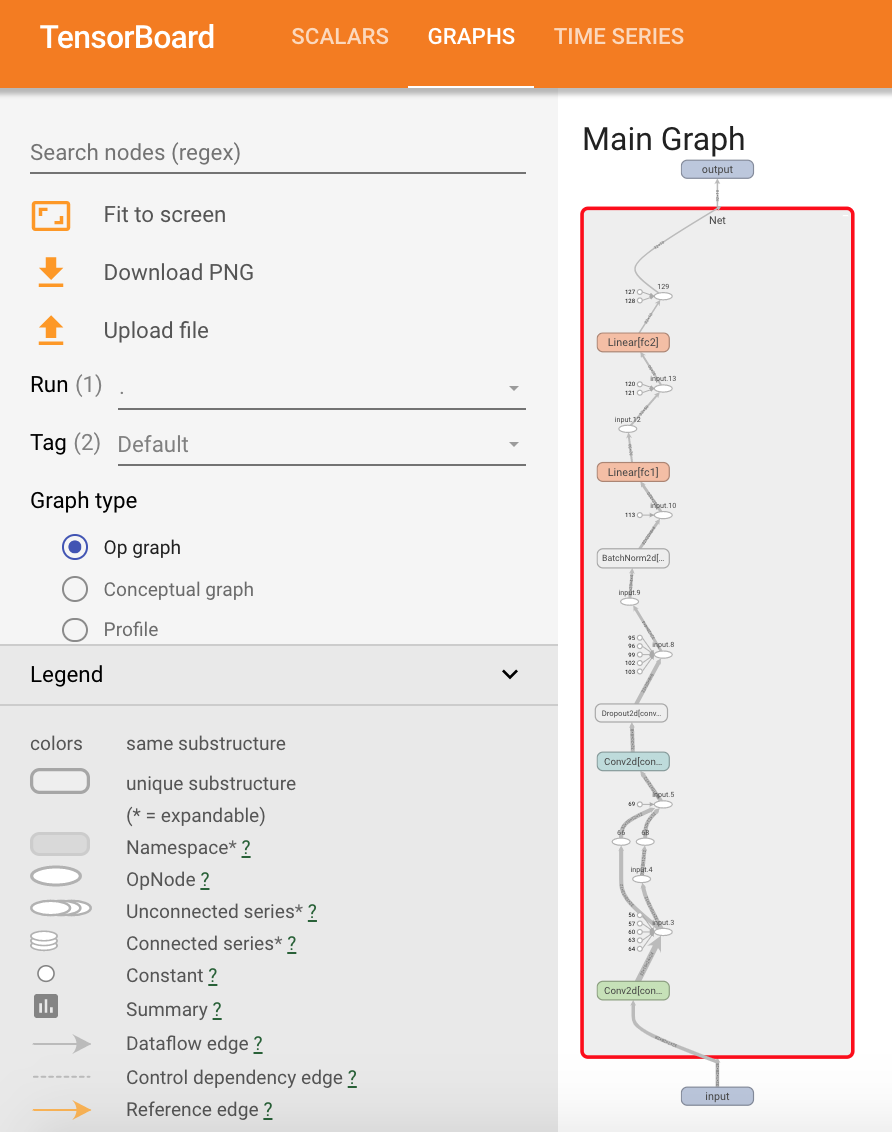

In [282]:
writer.close()

### (3) loss

In [283]:
dtype = torch.FloatTensor
writer = SummaryWriter(log_dir='logs',comment='Linear')
np.random.seed(100) 
x_train = np.linspace(-1, 1, 100).reshape(100,1) 
y_train = 3*np.power(x_train, 2) +2+ 0.2*np.random.rand(x_train.size).reshape(100,1) 

input_size = x_train.shape[1]
output_size = y_train.shape[1]
model = nn.Linear(input_size, output_size)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epoches):
    inputs = torch.from_numpy(x_train).type(dtype)
    targets = torch.from_numpy(y_train).type(dtype)

    output = model(inputs)
    loss = criterion(output, targets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # 保存loss的数据与epoch数值
    writer.add_scalar('训练损失值', loss, epoch)
    
!tensorboard --logdir=/Users/tinggao/Downloads/logs

Linear(in_features=1, out_features=1, bias=True)
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [284]:
writer.close()

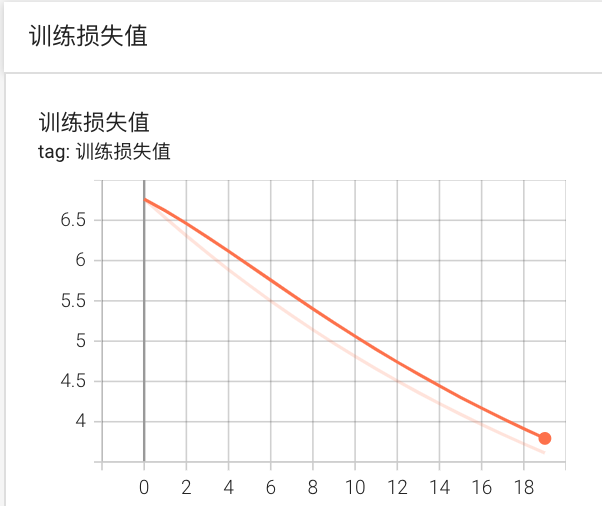

### (4) image

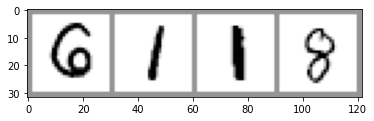

In [285]:
import torchvision.utils as vutils
writer = SummaryWriter('runs/mnist_experiment_1')

#定义预处理函数，这些预处理依次放在Compose函数中。
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#dataloader是一个可迭代对象，可以使用迭代器一样使用。
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))    

for ii in range(4):
    dataiter = iter(train_loader)
    images, labels = dataiter.next()

    # create grid of images
    img_grid = torchvision.utils.make_grid(images)
    
    # # show images
    matplotlib_imshow(img_grid, one_channel=True)
    
    # write to tensorboard
    writer.add_image('four_mnist_images' + str(ii), img_grid)

In [233]:
!tensorboard --logdir=/Users/tinggao/Downloads/runs/mnist_experiment_1
writer.close()

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


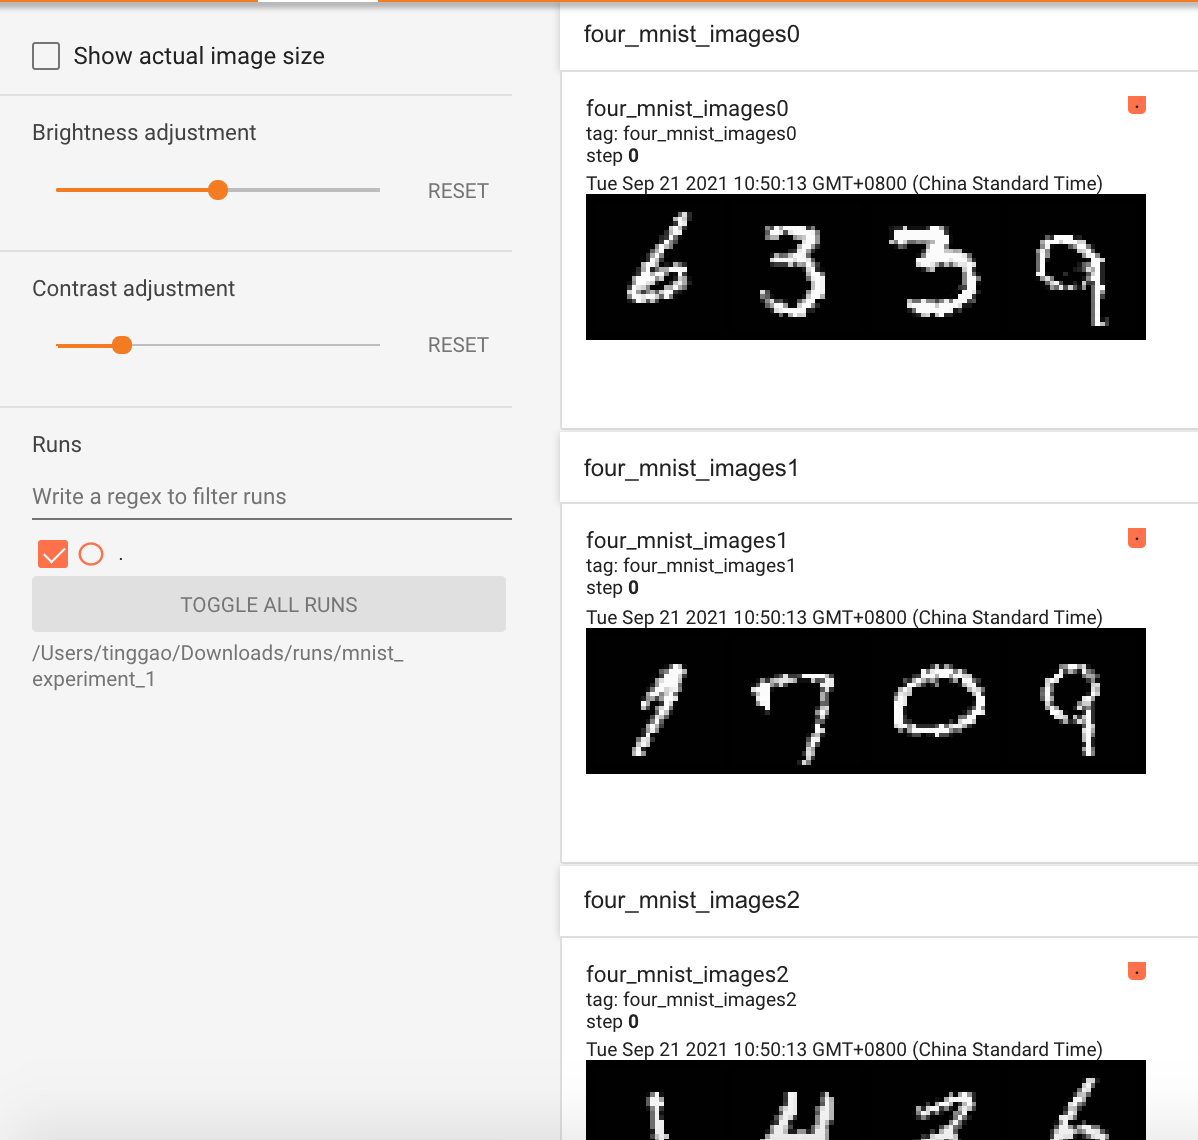

### (5) Feature map

In [289]:
import torch
import torchvision
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
sys.path.append(os.getcwd()+'/data')
mypath = sys.path.pop()

In [304]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [317]:
len(trainset)

50000

In [305]:
import torch.nn as nn
import torch.nn.functional as F
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=5,stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=36,kernel_size=3,stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296,32)
        self.fc2 = nn.Linear(32,10)      

    def forward(self,x):
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(-1,36*6*6)
        x=F.relu(self.fc2(F.relu(self.fc1(x))))
        return x

net = CNNNet()
net=net.to(device)

In [306]:
import torch.optim as optim
LR=0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

In [307]:
#初始化数据
for m in net.modules():
    if isinstance(m,nn.Conv2d):
        nn.init.normal_(m.weight)
        nn.init.xavier_normal_(m.weight)
        nn.init.kaiming_normal_(m.weight)#卷积层参数初始化
        nn.init.constant_(m.bias, 0)
    elif isinstance(m,nn.Linear):
        nn.init.normal_(m.weight)#全连接层参数初始化

In [318]:
#训练模型
for epoch in range(1):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 权重参数梯度清零
        optimizer.zero_grad()

        # 正向及反向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 显示损失值
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.303
Finished Training


In [319]:
import torchvision.utils as vutils
writer = SummaryWriter(log_dir='logs',comment='feature map')

In [320]:
for i, data in enumerate(trainloader, 0):
        # 获取训练数据
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        x=inputs[0].unsqueeze(0)
        break

In [321]:
img_grid = vutils.make_grid(x, normalize=True, scale_each=True, nrow=2)

net.eval()
for name, layer in net._modules.items():

    # 为fc层预处理x
    x = x.view(x.size(0), -1) if "fc" in name else x
    print(x.size())

    x = layer(x)
    print(f'{name}')

    # 查看卷积层的特征图
    if  'layer' in name or 'conv' in name:
        x1 = x.transpose(0, 1)  # C，B, H, W  ---> B，C, H, W
        img_grid = vutils.make_grid(x1, normalize=True, scale_each=True, nrow=4)  # normalize进行归一化处理
        writer.add_image(f'{name}_feature_maps', img_grid, global_step=0)

torch.Size([1, 3, 32, 32])
conv1
torch.Size([1, 16, 28, 28])
pool1
torch.Size([1, 16, 14, 14])
conv2
torch.Size([1, 36, 12, 12])
pool2
torch.Size([1, 1296])
fc1
torch.Size([1, 32])
fc2


In [328]:
!tensorboard --logdir=/Users/tinggao/Downloads/logs/feature_map

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [324]:
writer.close()

In [248]:
# def conv3x3(in_channels, out_channels, stride=1):
#     return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
#                      stride=stride, padding=1, bias=False)


# # ResNet
# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes = 10):   # block为残差模块
#         super(ResNet, self).__init__()
#         self.in_channels = 16
#         self.conv = conv3x3(3, 16)
#         self.bn = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self.make_layer(block, 16, layers[0], 1)   # 残差模块
#         self.layer2 = self.make_layer(block, 32, layers[1], 2)
#         self.layer3 = self.make_layer(block, 64, layers[2], 2)
#         self.avg_pool = nn.AvgPool2d(8)    # kernel_size = 8
#         self.fc = nn.Linear(64, num_classes)

#     def make_layer(self, block, out_channels, blocks, stride=1):
#         downsample = None
#         if (stride != 1) or (self.in_channels != out_channels):
#             downsample = nn.Sequential(
#                 conv3x3(self.in_channels, out_channels, stride=stride),
#                 nn.BatchNorm2d(out_channels)
#             )
#         layers = []
#         layers.append(block(self.in_channels, out_channels, stride, downsample))
#         self.in_channels = out_channels
#         for i in range(1, blocks):
#             layers.append(block(out_channels, out_channels))
#         return nn.Sequential(*layers)    # 把一个列表变成一个层的函数

#     def forward(self, x):
#         out = self.conv(x)
#         out = self.bn(out)
#         out = self.relu(out)
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.avg_pool(out)
#         out = out.reshape(out.size(0), -1)   # 1*1*64 features
#         out = self.fc(out)
#         return out

Object `        return out` not found.


In [252]:
# import torch
# import torch.nn as nn
# import torchvision
# import torchvision.transforms as transforms


# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Hyper-parameters
# num_epochs = 80
# batch_size = 100
# learning_rate = 0.01

# #定义预处理函数，这些预处理依次放在Compose函数中。
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
# #下载数据，并对数据进行预处理
# train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
# test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# #dataloader是一个可迭代对象，可以使用迭代器一样使用。
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# # 3x3 convolution
# def conv3x3(in_channels, out_channels, stride=1):
#     return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
#                      stride=stride, padding=1, bias=False)

# # Residual block
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1, downsample=None):
#         super(ResidualBlock, self).__init__()
#         self.conv1 = conv3x3(in_channels, out_channels, stride)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = conv3x3(out_channels, out_channels)
#         self.bn2 = nn.BatchNorm2d(out_channels)
#         self.downsample = downsample
        
#     def forward(self, x):
#         residual = x
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.conv2(out)
#         out = self.bn2(out)
#         if self.downsample:
#             residual = self.downsample(x)
#         out += residual
#         out = self.relu(out)
#         return out

# # ResNet
# class ResNet(nn.Module):
#     def __init__(self, block, layers, num_classes=10):
#         super(ResNet, self).__init__()
#         self.in_channels = 64
#         self.conv = conv3x3(3, 16)
#         self.bn = nn.BatchNorm2d(16)
#         self.relu = nn.ReLU(inplace=True)
#         self.layer1 = self.make_layer(block, 16, layers[0])
#         self.layer2 = self.make_layer(block, 32, layers[1], 2)
#         self.layer3 = self.make_layer(block, 64, layers[2], 2)
#         self.avg_pool = nn.AvgPool2d(8)
#         self.fc = nn.Linear(64, num_classes)
        
#     def make_layer(self, block, out_channels, blocks, stride=1):
#         downsample = None
#         if (stride != 1) or (self.in_channels != out_channels):
#             downsample = nn.Sequential(
#                 conv3x3(self.in_channels, out_channels, stride=stride),
#                 nn.BatchNorm2d(out_channels))
#         layers = []
#         layers.append(block(self.in_channels, out_channels, stride, downsample))
#         self.in_channels = out_channels
#         for i in range(1, blocks):
#             layers.append(block(out_channels, out_channels))
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         out = self.conv(x)
#         out = self.bn(out)
#         out = self.relu(out)
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.avg_pool(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc(out)
#         return out
    
# model = ResNet(ResidualBlock, [2, 2, 2]).to(device)


# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# # For updating learning rate
# def update_lr(optimizer, lr):    
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = lr

# # Train the model
# total_step = len(train_loader)
# curr_lr = learning_rate
# for epoch in range(num_epochs):
#     for i, (images, labels) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)
        
#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
#                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

#     # Decay learning rate
#     if (epoch+1) % 20 == 0:
#         curr_lr /= 2
#         update_lr(optimizer, curr_lr)

# # # Test the model
# # model.eval()
# # with torch.no_grad():
# #     correct = 0
# #     total = 0
# #     for images, labels in test_loader:
# #         images = images.to(device)
# #         labels = labels.to(device)
# #         outputs = model(images)
# #         _, predicted = torch.max(outputs.data, 1)
# #         total += labels.size(0)
# #         correct += (predicted == labels).sum().item()

# #     print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

# # # Save the model checkpoint
# # torch.save(model.state_dict(), 'resnet.ckpt')

example: Resnet: 

https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/deep_residual_network/main.py

In [253]:
# #定义预处理函数，这些预处理依次放在Compose函数中。
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
# #下载数据，并对数据进行预处理
# train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
# test_dataset = mnist.MNIST('./data', train=False, transform=transform)
# #dataloader是一个可迭代对象，可以使用迭代器一样使用。
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# model = ResNet(2, 4)
# criterion = nn.CrossEntropyLoss()


# # 训练整个网络
# total_step = len(train_loader)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# for epoch in range(num_epoches):
#     for i, (images, labels) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)

#         # 正向传播
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # 反向传播
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         if (i+1) % 100 == 0:
#             print(f'Epoch {epoch+1}/{num_epoches}, Step {i+1}/{total_step}, {loss.item()}')   # 不要忘了item()
# torch.save(model.state_dict(), 'ResnetMnist.pt')

In [261]:
# coding: utf-8
import os
import torch
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # 定义权值初始化
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight.data, 0, 0.01)
                m.bias.data.zero_()


net = Net()     # 创建一个网络
# pretrained_dict = torch.load(os.path.join("..", "2_model", "net_params.pkl"))
# net.load_state_dict(pretrained_dict)

writer = SummaryWriter(log_dir='/Users/tinggao/Downloads/runs/result_weights')
params = net.state_dict()
for k, v in params.items():
    if 'conv' in k and 'weight' in k:

        c_int = v.size()[1]     # 输入层通道数
        c_out = v.size()[0]     # 输出层通道数

        # 以feature map为单位，绘制一组卷积核，一张feature map对应的卷积核个数为输入通道数
        for j in range(c_out):
            print(k, v.size(), j)
            kernel_j = v[j, :, :, :].unsqueeze(1)       # 压缩维度，为make_grid制作输入
            kernel_grid = vutils.make_grid(kernel_j, normalize=True, scale_each=True, nrow=c_int)   # 1*输入通道数, w, h
            writer.add_image(k+'_split_in_channel', kernel_grid, global_step=j)     # j 表示feature map数

        # 将一个卷积层的卷积核绘制在一起，每一行是一个feature map的卷积核
        k_w, k_h = v.size()[-1], v.size()[-2]
        kernel_all = v.view(-1, 1, k_w, k_h)
        kernel_grid = vutils.make_grid(kernel_all, normalize=True, scale_each=True, nrow=c_int)  # 1*输入通道数, w, h
        writer.add_image(k + '_all', kernel_grid, global_step=666)
        
writer.close()

conv1.weight torch.Size([6, 3, 5, 5]) 0
conv1.weight torch.Size([6, 3, 5, 5]) 1
conv1.weight torch.Size([6, 3, 5, 5]) 2
conv1.weight torch.Size([6, 3, 5, 5]) 3
conv1.weight torch.Size([6, 3, 5, 5]) 4
conv1.weight torch.Size([6, 3, 5, 5]) 5
conv2.weight torch.Size([16, 6, 5, 5]) 0
conv2.weight torch.Size([16, 6, 5, 5]) 1
conv2.weight torch.Size([16, 6, 5, 5]) 2
conv2.weight torch.Size([16, 6, 5, 5]) 3
conv2.weight torch.Size([16, 6, 5, 5]) 4
conv2.weight torch.Size([16, 6, 5, 5]) 5
conv2.weight torch.Size([16, 6, 5, 5]) 6
conv2.weight torch.Size([16, 6, 5, 5]) 7
conv2.weight torch.Size([16, 6, 5, 5]) 8
conv2.weight torch.Size([16, 6, 5, 5]) 9
conv2.weight torch.Size([16, 6, 5, 5]) 10
conv2.weight torch.Size([16, 6, 5, 5]) 11
conv2.weight torch.Size([16, 6, 5, 5]) 12
conv2.weight torch.Size([16, 6, 5, 5]) 13
conv2.weight torch.Size([16, 6, 5, 5]) 14
conv2.weight torch.Size([16, 6, 5, 5]) 15


In [266]:
# ------------------------------------ step 2/4 : 网络初始化----------------------------------------------

net = Net()     # 创建一个网络
net.initialize_weights()    # 初始化权值

# ------------------------------------ step 3/4 : 定义损失函数和优化器 ------------------------------------

criterion = nn.CrossEntropyLoss()                                                   # 选择损失函数
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, dampening=0.1)    # 选择优化器
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)     # 设置学习率下降策略

# ------------------------------------ step 4/4 : 训练 --------------------------------------------------

max_epoch = 80
for epoch in range(max_epoch):

    loss_sigma = 0.0    # 记录一个epoch的loss之和
    correct = 0.0
    total = 0.0
    scheduler.step()  # 更新学习率

    for i, data in enumerate(train_loader):
        # 获取图片和标签
        inputs, labels = data

        # forward, backward, update weights
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 统计预测信息
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).squeeze().sum().numpy()
        loss_sigma += loss.item()

        # 每10个iteration 打印一次训练信息，loss为10个iteration的平均
        if i % 10 == 9:
            loss_avg = loss_sigma / 10
            loss_sigma = 0.0
            print("Training: Epoch[{:0>3}/{:0>3}] Iteration[{:0>3}/{:0>3}] Loss: {:.4f} Acc:{:.2%}".format(
                epoch + 1, max_epoch, i + 1, len(train_loader), loss_avg, correct / total))

    # 每个epoch，记录梯度，权值
    for name, layer in net.named_parameters():
        writer.add_histogram(name + '_grad', layer.grad.cpu().data.numpy(), epoch)
        writer.add_histogram(name + '_data', layer.cpu().data.numpy(), epoch)


RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[4, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [258]:
!tensorboard --logdir=/Users/tinggao/Downloads/runs/result_weights
writer.close()

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
